In [1]:
import itertools
import os
import functools
import dataclasses
import packaging.version
import importlib
from typing import List, Sequence, Set, Iterator, Optional

import libmambapy
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import mamba_error_reporting as mer

pd.set_option("max_colwidth", None)
pd.set_option("display.max_columns", None)

%matplotlib inline

def reload():
    """Reload all mer modules (for dev purposes)."""
    for m in mer.__all__:
        importlib.reload(getattr(mer, m))

## Previous error message

In [2]:
reload()

solver, pool = mer.problems.create_pubgrub_missing()

success = solver.solve()
if not success:
    print(mer.messaging.old_error_report(solver))

Mamba failed to solve. The reported errors are:
   Encountered problems while solving:
     - nothing provides libnothere >1.0 needed by dropdown-2.9.3
   


## Raw libsolv data

In [3]:
reload()

pbs = mer.analysis.all_problems_structured_df(solver)
deps = mer.analysis.select_solvables_df(
    pool, pbs[~pbs.dependency.isnull()].dependency_id.drop_duplicates()
)
solvables = mer.analysis.id_to_pkg_info_df(pool,
    itertools.chain(
    pbs[pbs.source_is_pkg].source_id,
    pbs[pbs.target_is_pkg].target_id,
    deps.solvable_id
)).drop_duplicates().set_index('id').sort_index()

## Graph compression

In [4]:
reload()
pb_data = mer.algorithm.ProblemData.from_libsolv(solver, pool)
cp_data = mer.algorithm.compress_graph(pb_data)

==================================================== Original graph ====================================================


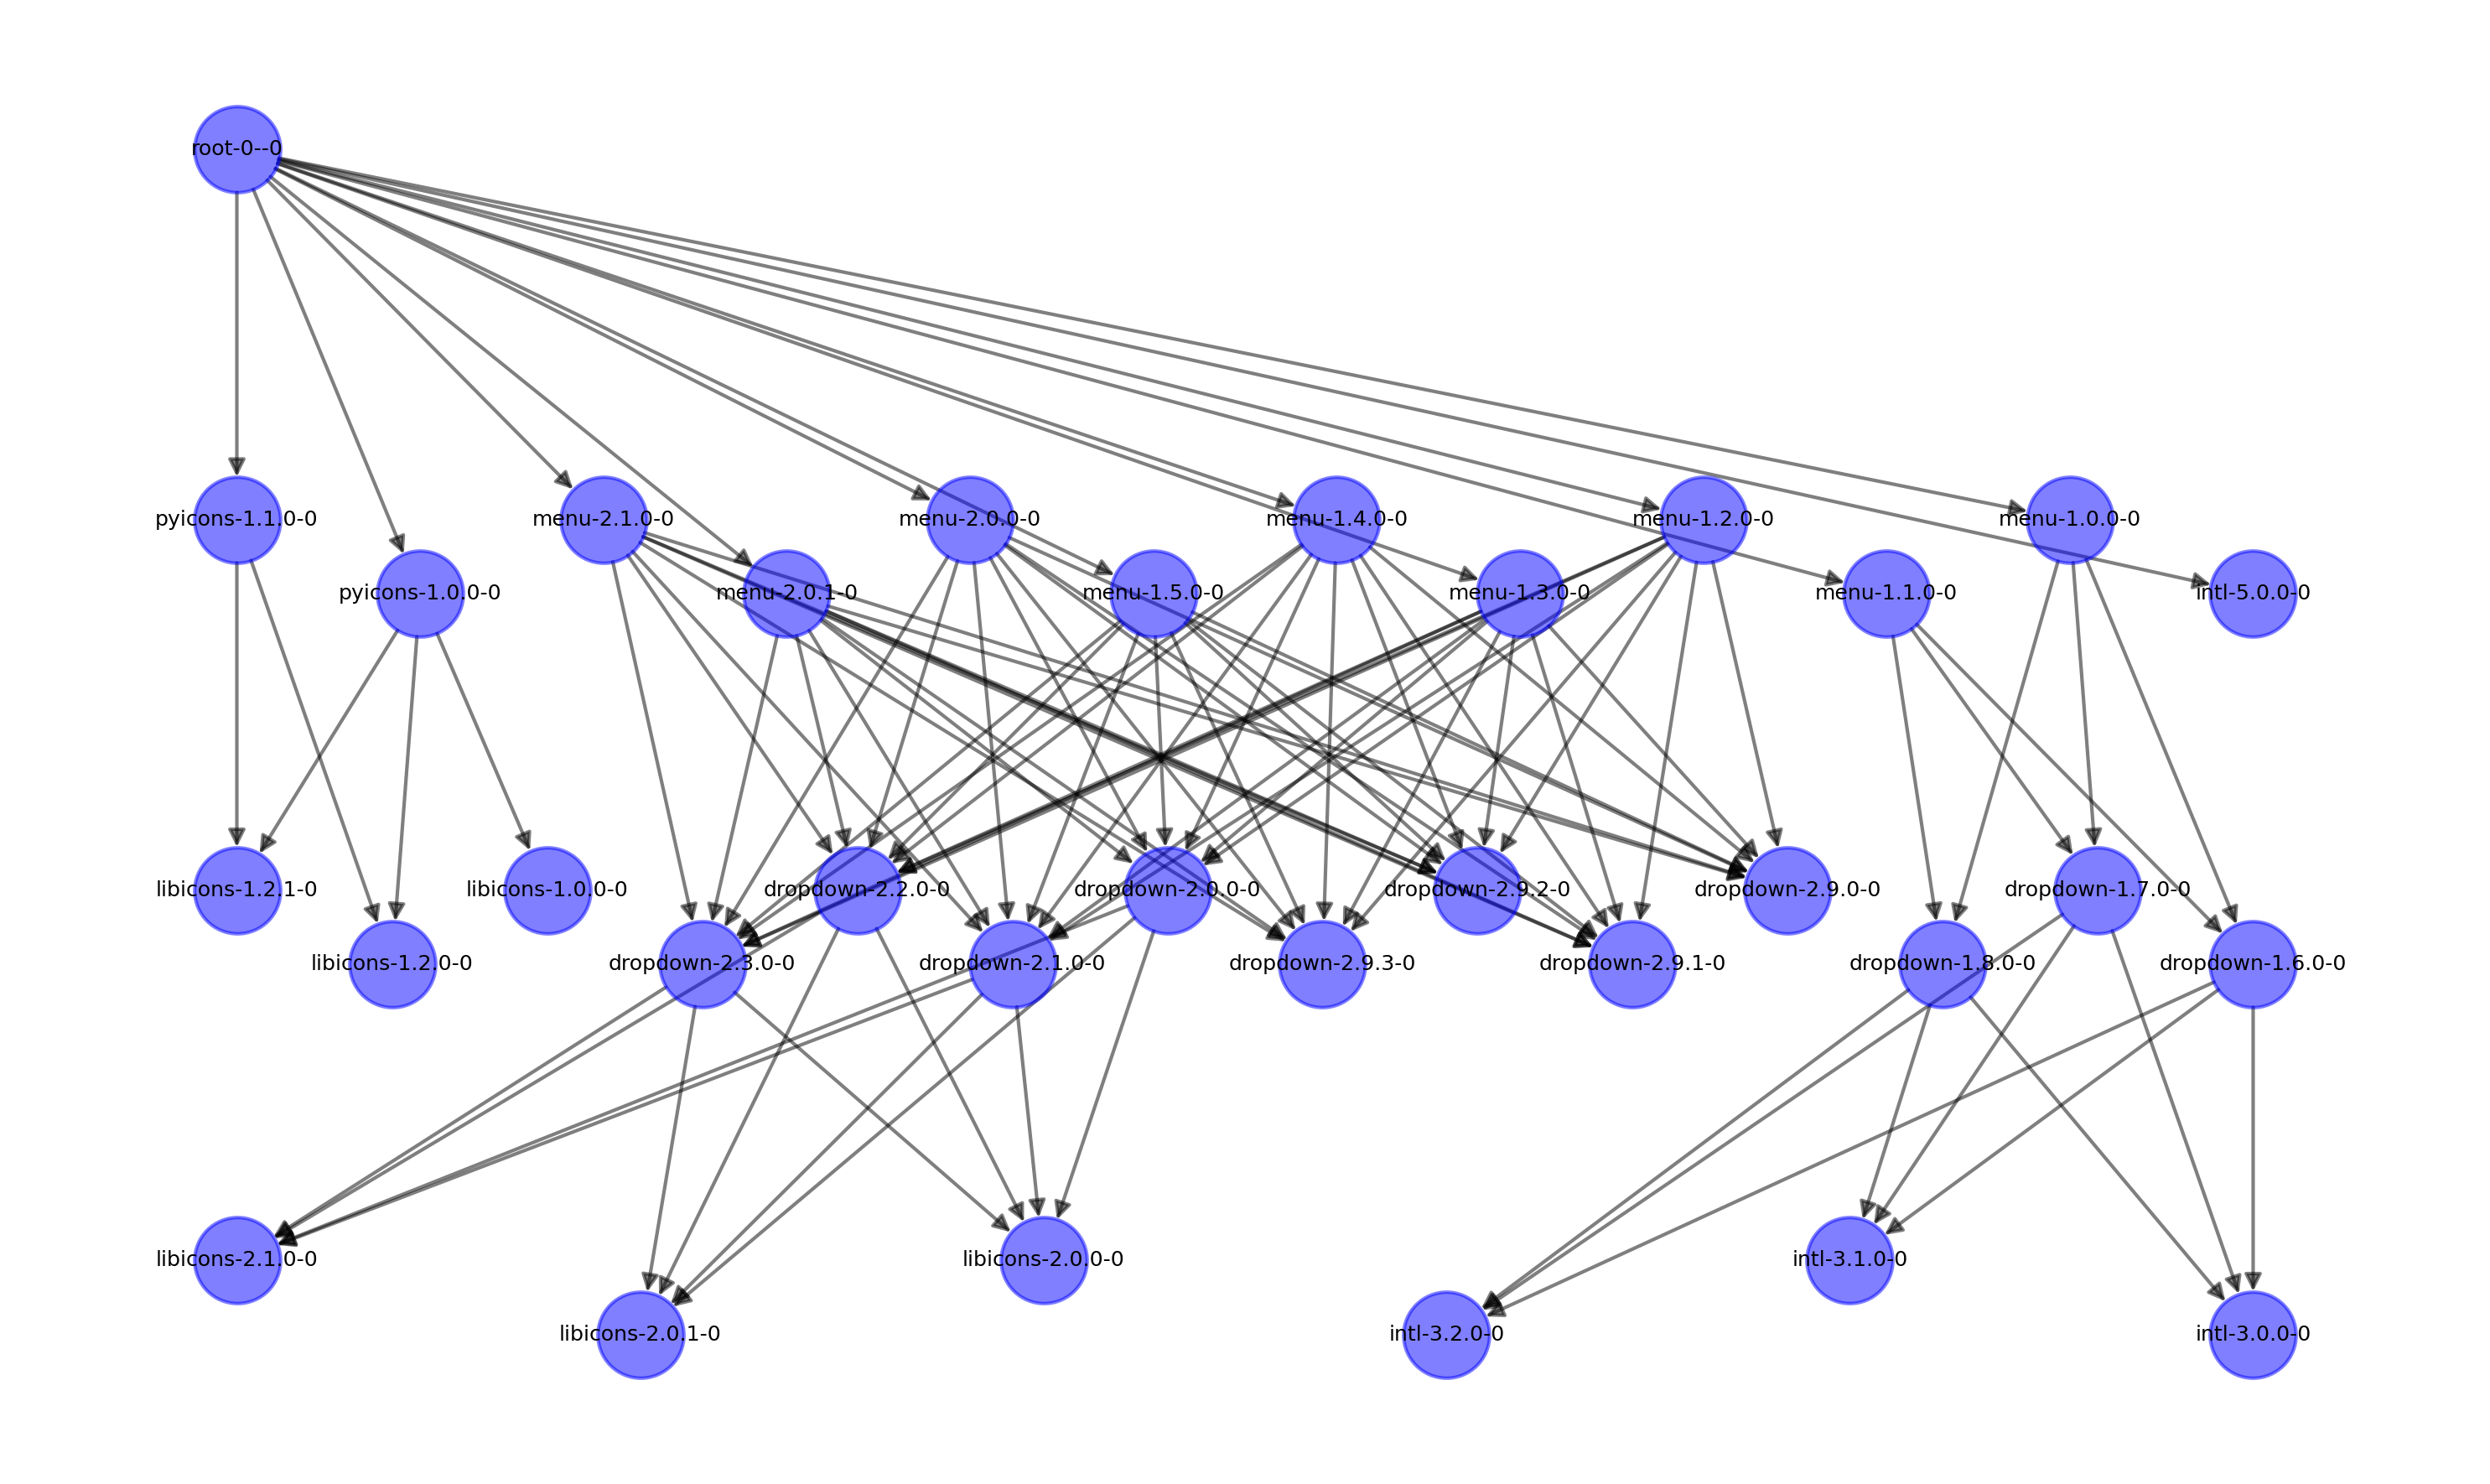

=================================================== Compressed graph ===================================================


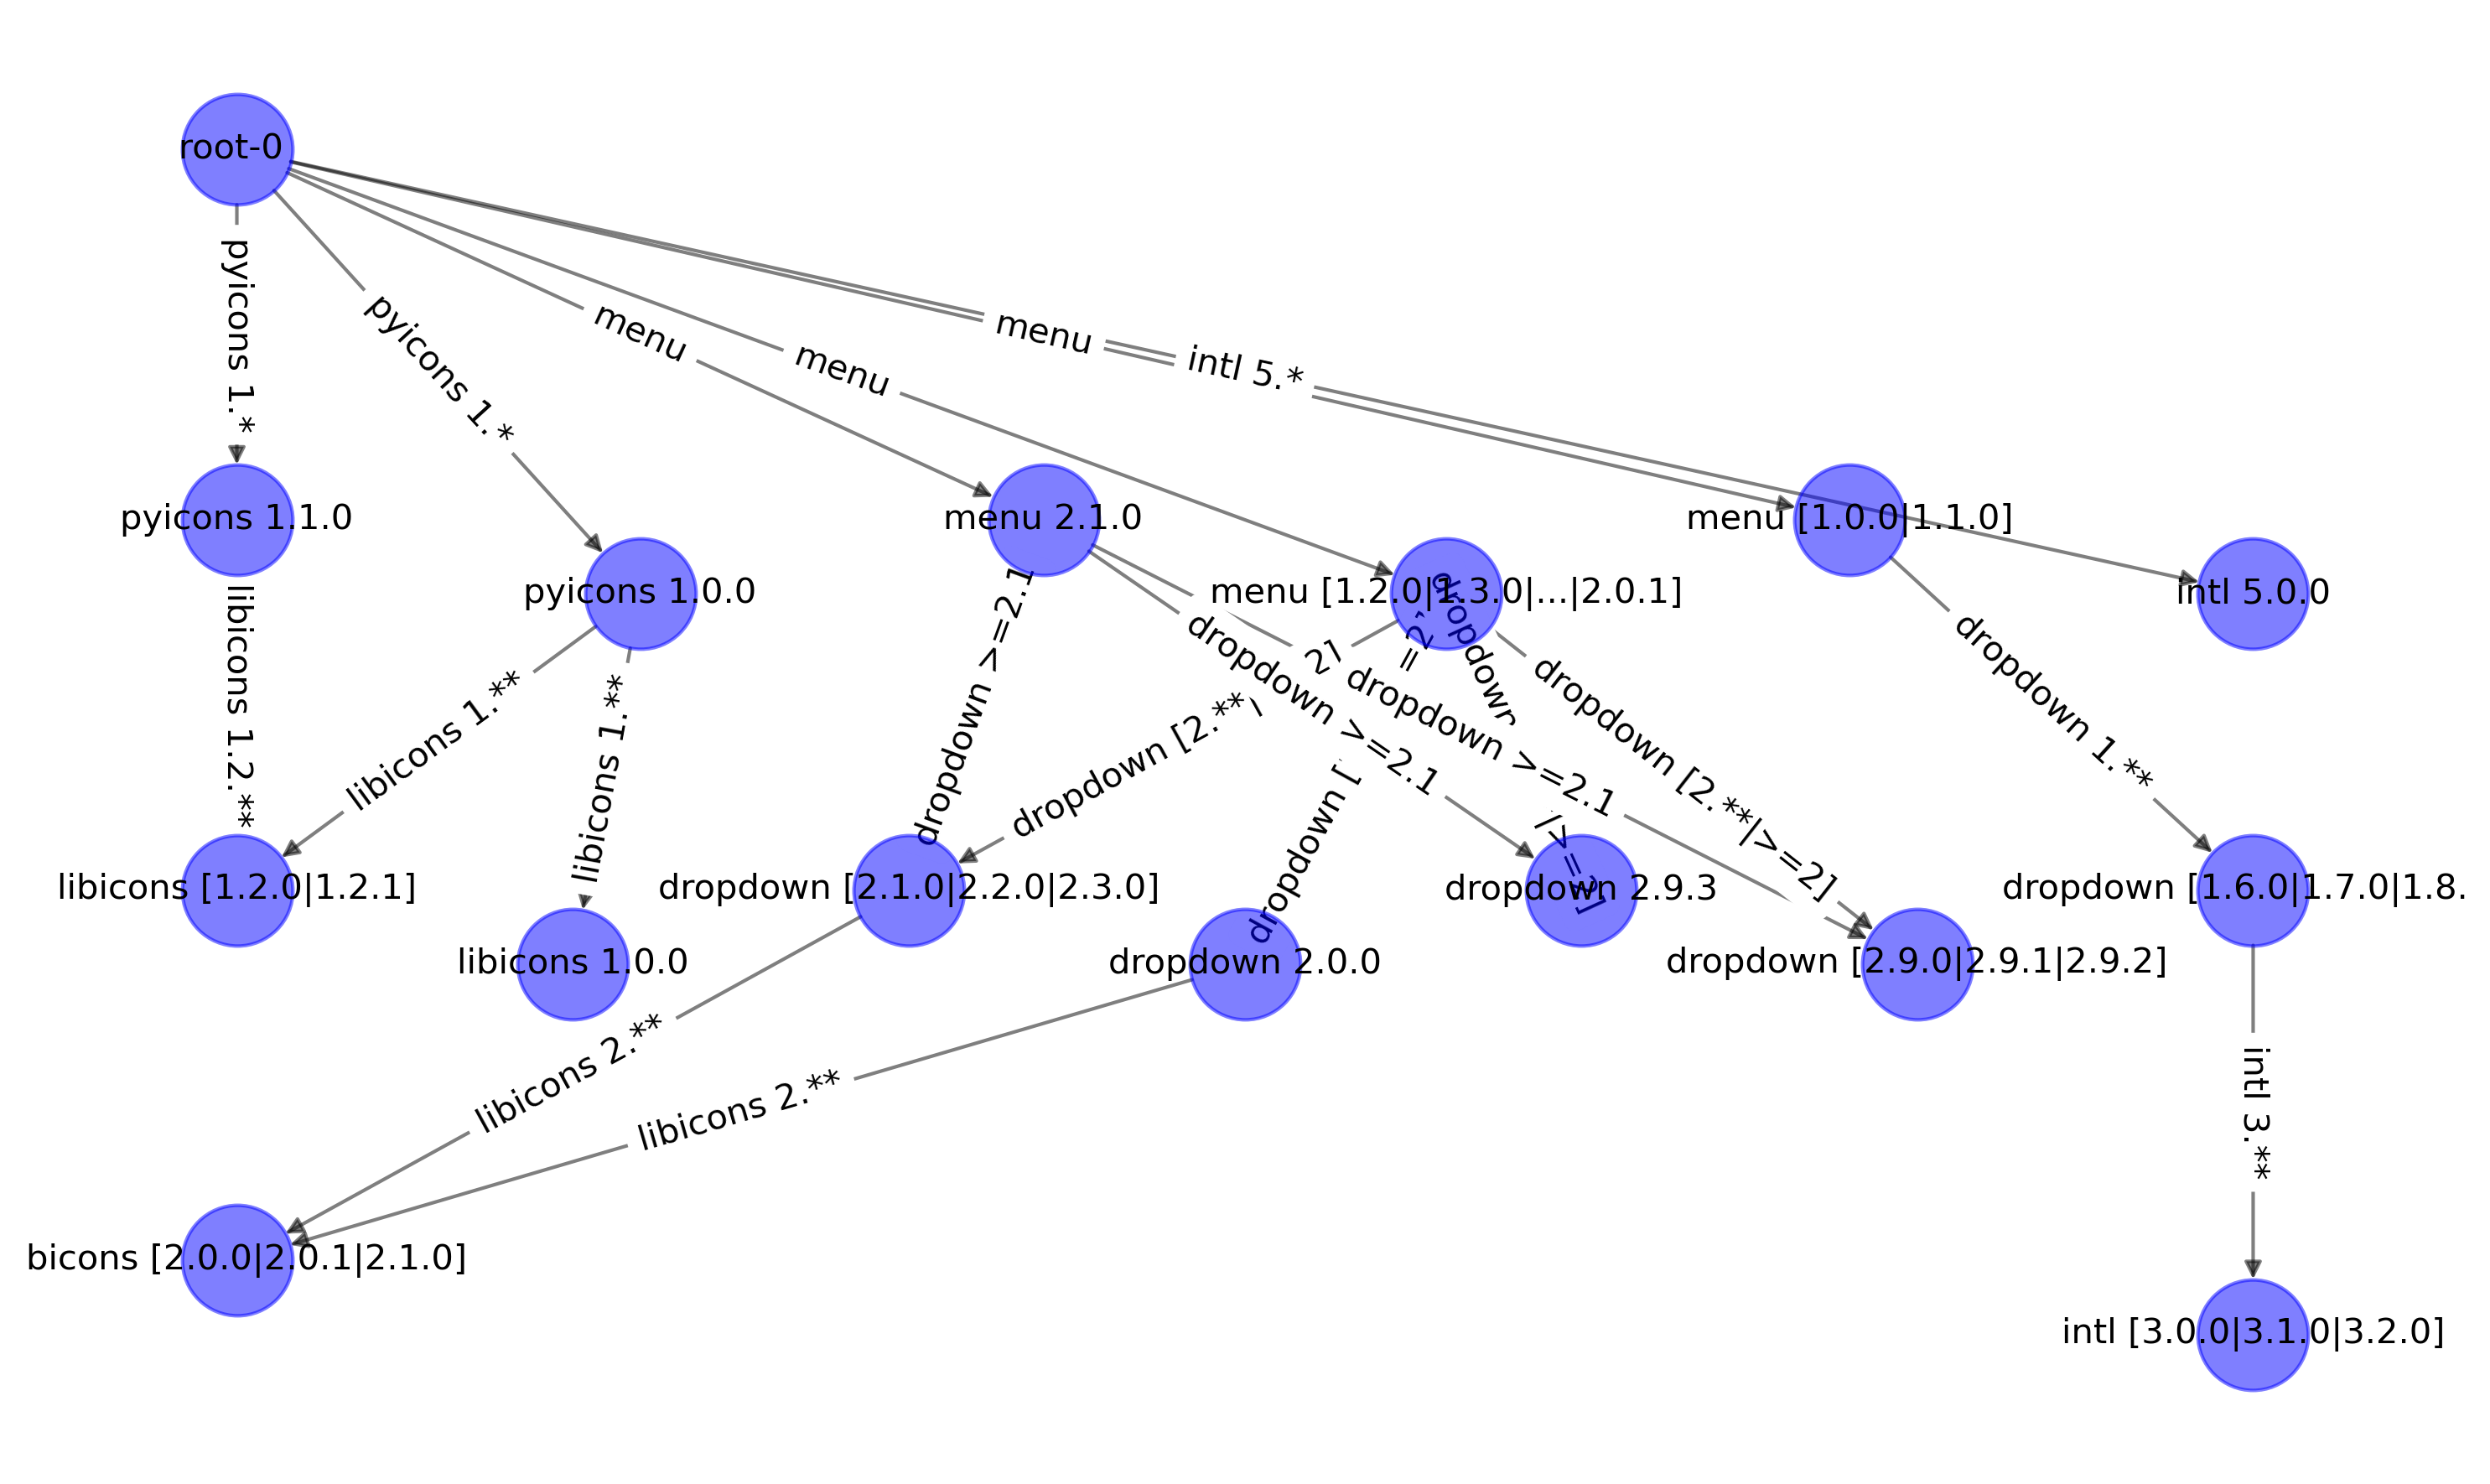

In [5]:
print("{:=^120}".format(" Original graph "))
mer.plot.plot_solvable_dag(pb_data)
print("{:=^120}".format(" Compressed graph "))
mer.plot.plot_group_dag(pb_data, cp_data)

## Error message

In [6]:
reload()
print(mer.algorithm.explain_graph(pb_data, cp_data))

Error: Could not find any compatible versions for requested packages intl 5.*, pyicons 1.*, menu .

The following packages conflict with one another
├─ pyicons 1.* is installable with the potential options
│  ├─ pyicons 1.0.0, which requires
│  │  └─ libicons 1.** with the potential options
│  │     ├─ libicons 1.0.0, which can be installed;
│  │     └─ libicons [1.2.0|1.2.1], which can be installed;
│  └─ pyicons 1.1.0, which requires
│     └─ libicons 1.2.**, which can be installed;
├─ menu is installable with the potential options
│  ├─ menu [1.0.0|1.1.0], which requires
│  │  └─ dropdown 1.**, which requires
│  │     └─ intl 3.**, which can be installed;
│  ├─ menu [1.2.0|1.3.0|...|2.0.1], which requires
│  │  └─ dropdown [2.**|>=2] with no viable options
│  │     ├─ dropdown 2.0.0, which requires
│  │     │  └─ libicons 2.**, which conflicts with any installable versions of libicons;
│  │     ├─ dropdown [2.1.0|2.2.0|2.3.0], which requires
│  │     │  └─ libicons 2.**, which confl